# $\color{blue}{\text{MADE}}$ $\bullet$ $\color{red}{\text{NLP}}$ $\bullet$ Assignment 01
### Преподаватель: [*Радослав Нейчев*](https://ml-mipt.github.io/team.html)
### Выполнил: $\text{Саит Шарипов, группа MADE-DS-22}$
### 📝 Simple text processing
* * *

In [1]:
# For visualization.
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15, 8)
legend_fontsize = 18
axis_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
rc('axes', **{'titlesize': '16', 'labelsize': '16'})
rc('legend', **{'fontsize': '16'})
rc('figure', **{'dpi' : 300})

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve


def roc_auc_plot(model, X_train, X_test, y_train, y_test, is_nn=False):
    for name, X, y, model in [
        ('train', X_train, y_train, model),
        ('test ', X_test, y_test, model)
    ]:
        if is_nn:
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            proba = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.grid()

### My implement of Bag of Words and TF-IDF

<font color='darkviolet'><i> 
✏️ Перенесем сюда файл `features.py`. Далее не будем писать конструкции типа `from features import BoW`. Это для удобства запуска ноутбука на Google Colab.
</i></font>

In [3]:
from collections import Counter
from sklearn.base import TransformerMixin
from typing import List, Union
import numpy as np
from itertools import chain


class BoW(TransformerMixin):
    """
    Bag of words tranformer class
    
    check out:
    https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html
    to know about TransformerMixin class
    """

    def __init__(self, k: int):
        """
        :param k: number of most frequent tokens to use
        """
        self.k = k
        # list of k most frequent tokens
        self.bow = None

    def fit(self, X: np.ndarray, y=None):
        """
        :param X: array of texts to be trained on
        """
        # task: find up to self.k most frequent tokens in texts_train,
        # sort them by number of occurences (highest first)
        # store most frequent tokens in self.bow

        token_counts = Counter(' '.join(X).split())
        self.bow = [token for token, frequency in token_counts.most_common(self.k)]

        # fit method must always return self
        return self

    def _text_to_bow(self, text: str) -> np.ndarray:
        """
        convert text string to an array of token counts. Use self.bow.
        :param text: text to be transformed
        :return bow_feature: feature vector, made by bag of words
        """
        bow_vector = np.zeros(len(self.bow))
        token_counts = Counter(text.split())
        for i, token in enumerate(self.bow):
            if token in token_counts:
                bow_vector[i] = token_counts[token]
        return np.array(bow_vector, "float32")

    def transform(self, X: np.ndarray, y=None) -> np.ndarray:
        """
        :param X: array of texts to transform
        :return: array of transformed texts
        """
        assert self.bow is not None
        return np.stack([self._text_to_bow(text) for text in X])

    def get_vocabulary(self) -> Union[List[str], None]:
        return self.bow


class TfIdf(TransformerMixin):
    """
    Tf-Idf tranformer class
    if you have troubles implementing Tf-Idf, check out:
    https://streamsql.io/blog/tf-idf-from-scratch
    """

    def __init__(self, k: int = None, normalize: bool = False):
        """
        :param k: number of most frequent tokens to use
        if set k equals None, than all words in train must be considered
        :param normalize: if True, you must normalize each data sample
        after computing tf-idf features
        """
        self.k = k
        self.normalize = normalize

        # self.idf[term] = log(total # of documents / # of documents with term in it)
        self.idf = {}

    def fit(self, X: np.ndarray, y=None):
        """
        :param X: array of texts to be trained on
        """

        token_counts = Counter(' '.join(X).split())
        if self.k is None:
            self.k = len(token_counts)

        # Считаем, в скольких уникальных документах встречается каждое слово.
        unique_words_docs = [list(set(x.split())) for x in X]
        document_frequency = Counter(chain.from_iterable(unique_words_docs))

        # Число документов.
        n_docs = len(X)

        # Считаем idf:
        for token in token_counts:
            self.idf[token] = np.log(n_docs / (document_frequency[token] + 1))

        return self

    def _text_to_tf_idf(self, text: str) -> np.ndarray:
        """
        convert text string to an array tf-idfs.
        *Note* don't forget to normalize, when self.normalize == True
        :param text: text to be transformed
        :return tf_idf: tf-idf features
        """
        tf_idf_vector = np.zeros(len(self.idf))
        token_counts = Counter(text.split())
        for i, token in enumerate(self.idf):
            if token in token_counts:
                tf_idf_vector[i] = token_counts[token] * self.idf[token]
        if self.normalize:
            if np.linalg.norm(tf_idf_vector) > 0:
                tf_idf_vector /= np.linalg.norm(tf_idf_vector)
        return np.array(tf_idf_vector, "float32")

    def transform(self, X: np.ndarray, y=None) -> np.ndarray:
        """
        :param X: array of texts to transform
        :return: array of transformed texts
        """
        assert self.idf is not None
        return np.stack([self._text_to_tf_idf(text) for text in X])

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

In [5]:
# In colab run this cell
! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/homeworks_advanced/assignment1_01_Word_Vectors/utils.py -nc
! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/homeworks_advanced/assignment1_01_Word_Vectors/features.py -nc

--2022-04-05 15:53:35--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/homeworks_advanced/assignment1_01_Word_Vectors/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-04-05 15:53:35 ERROR 404: Not Found.

--2022-04-05 15:53:35--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/homeworks_advanced/assignment1_01_Word_Vectors/features.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-04-05 15:53:35 ERROR 404: Not Found.



In [6]:
try:
    data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

File ‘comments.tsv’ already there; not retrieving.



In [7]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [8]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

In [9]:
print('train size = {}'.format(len(texts_train)))
print('test size = {}'.format(len(texts_test)))

train size = 500
test size = 500


__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [10]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [11]:
# task: preprocess each comment in train and test

texts_train = np.array([preprocess(text) for text in texts_train])
texts_test = np.array([preprocess(text) for text in texts_test])

In [12]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [13]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))


bow = BoW(k)
bow.fit(texts_train)

print('example features:', sorted(bow.get_vocabulary())[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', 'ீ']


In [14]:
X_train_bow = bow.transform(texts_train)
X_test_bow = bow.transform(texts_test)

In [15]:
# Small check that everything is done properly
bow_vocabulary = bow.get_vocabulary()
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [16]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

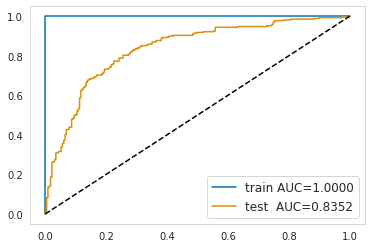

In [17]:
roc_auc_plot(bow_model, X_train_bow, X_test_bow, y_train, y_test)

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [18]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

<font color='darkviolet'><i> 
✏️ Внутреннее содержимое `utils.py`:
</i></font>

In [19]:
import numpy as np
from matplotlib import pyplot as plt


def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Validation accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()


In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = nn.Sequential()

model.add_module('layer1', nn.Linear(X_train_bow.shape[1], 2))
model.to(device, torch.float32)

Sequential(
  (layer1): Linear(in_features=5722, out_features=2, bias=True)
)

In [21]:
print(device)

cpu


Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [22]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [23]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
# Reduce learning rate when a metric has stopped improving.
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt)

In [24]:
X_train_bow_torch = torch.tensor(X_train_bow).to(device)
X_test_bow_torch = torch.tensor(X_test_bow).to(device)

y_train_torch = torch.tensor(y_train).to(device)
y_test_torch = torch.tensor(y_test).to(device)

Let's test that everything is fine

In [25]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

In [26]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [27]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # clear gradients
        opt.zero_grad()

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        loss.backward()

        # Adam step
        opt.step()

        local_train_loss_history.append(loss.data.cpu().numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

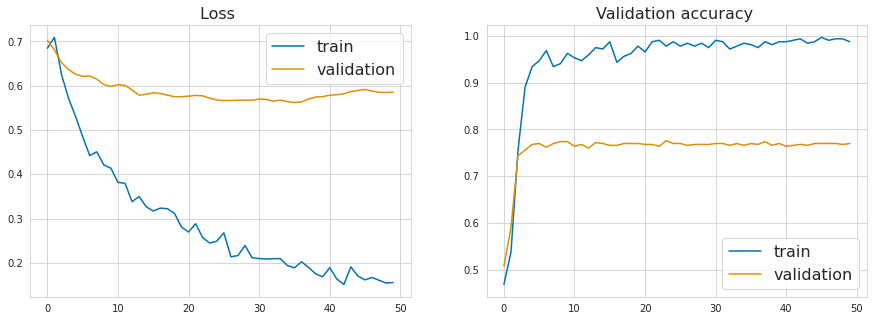

Sequential(
  (layer1): Linear(in_features=5722, out_features=2, bias=True)
)

In [28]:
train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

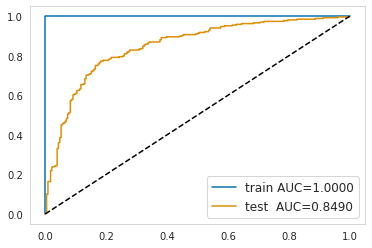

In [29]:
roc_auc_plot(model, X_train_bow_torch, X_test_bow_torch, y_train, y_test, is_nn=True)

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [30]:
print(k)

5722


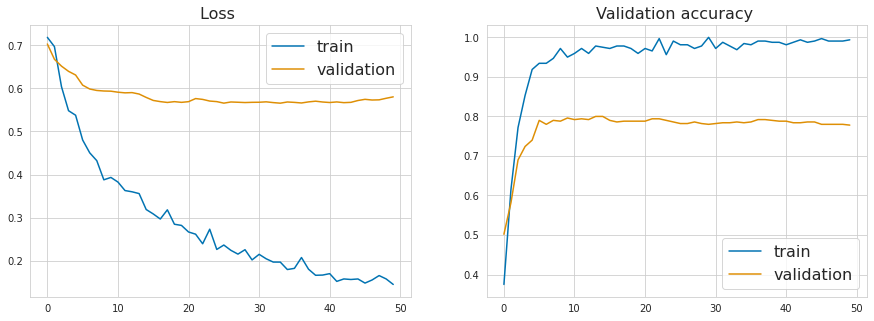

In [31]:
list_k = [tmp for tmp in range(500, 5700, 500)]
train_aucs = []
test_aucs = []

for k_iter in list_k:

    bow = BoW(k)
    bow.fit(texts_train)

    X_train_bow_tmp = bow.transform(texts_train)
    X_test_bow_tmp = bow.transform(texts_test)

    model = nn.Sequential()

    model.add_module('layer1', nn.Linear(X_train_bow_tmp.shape[1], 2))
    model.to(device, torch.float32)

    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt)

    X_train_bow_torch = torch.tensor(X_train_bow_tmp).to(device)
    X_test_bow_torch = torch.tensor(X_test_bow_tmp).to(device)

    y_train_torch = torch.tensor(y_train).to(device)
    y_test_torch = torch.tensor(y_test).to(device)

    train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

    proba_train = model(X_train_bow_torch).detach().cpu().numpy()[:, 1]
    proba_test = model(X_test_bow_torch).detach().cpu().numpy()[:, 1]

    auc_train = roc_auc_score(y_train, proba_train)
    auc_test = roc_auc_score(y_test, proba_test)

    train_aucs.append(auc_train)
    test_aucs.append(auc_test)

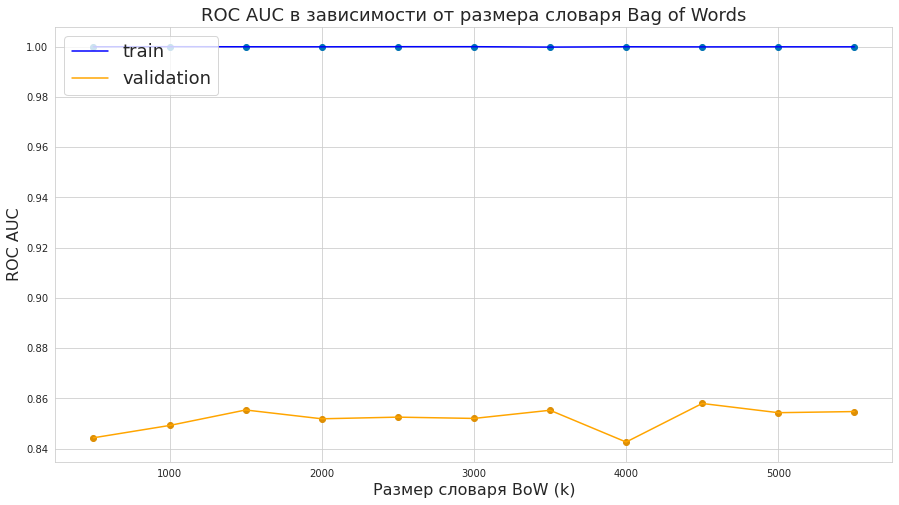

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

ax.margins(0.05)
ax.plot(list_k, train_aucs, label="train", color='b')
ax.plot(list_k, test_aucs, label="validation", color='orange')
ax.set_title("ROC AUC в зависимости от размера словаря Bag of Words", fontsize=legend_fontsize)
ax.set_xlabel("Размер словаря BoW (k)", fontsize=axis_fontsize)
ax.set_ylabel("ROC AUC", fontsize=axis_fontsize)
ax.legend(loc="upper left", fontsize=legend_fontsize)

# Для точек
plt.scatter(list_k, train_aucs)
plt.scatter(list_k, test_aucs)

plt.show()

<font color='darkviolet'><i> 
✏️ Интересно, что значительных успехов различий нет, ROC AUC в интервале $[0.84, 0.86]$. На train стабильная $1$, возможно мы на нем немноого переобучились.
</i></font>

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [33]:
k = min(10000, len(set(' '.join(texts_train).split())))


tf_idf = TfIdf(k)
tf_idf.fit(texts_train)

Same stuff about model and optimizers here (or just omit it, if you are using the same model as before).

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

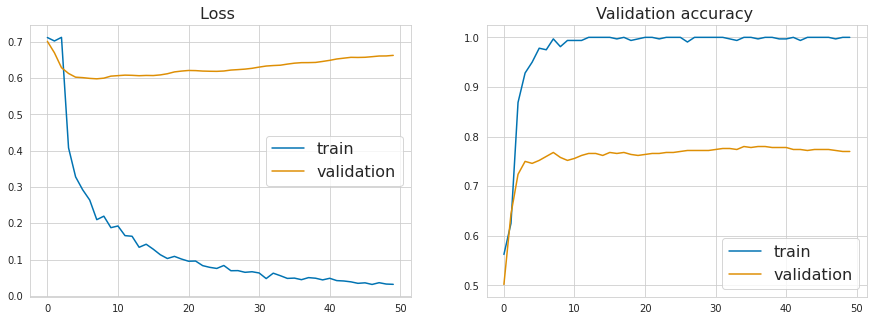

Sequential(
  (layer1): Linear(in_features=5722, out_features=2, bias=True)
)

In [34]:
X_train_tfidf = tf_idf.transform(texts_train)
X_test_tfidf = tf_idf.transform(texts_test)

model = nn.Sequential()
model.add_module('layer1', nn.Linear(X_train_tfidf.shape[1], 2))
model.to(device, torch.float32)

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt)

X_train_tfidf_torch = torch.tensor(X_train_tfidf).to(device)
X_test_tfidf_torch = torch.tensor(X_test_tfidf).to(device)
y_train_torch = torch.tensor(y_train).to(device)
y_test_torch = torch.tensor(y_test).to(device)

train_model(model, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch)

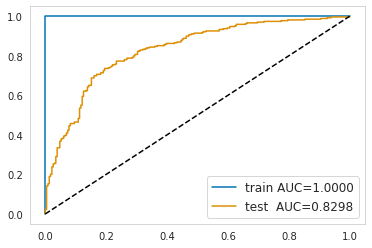

In [35]:
roc_auc_plot(model, X_train_tfidf_torch, X_test_tfidf_torch, y_train, y_test, is_nn=True)

<font color='darkviolet'><i> 
✏️ Попробуем с нормализацией вектора tf_idf:
</i></font>

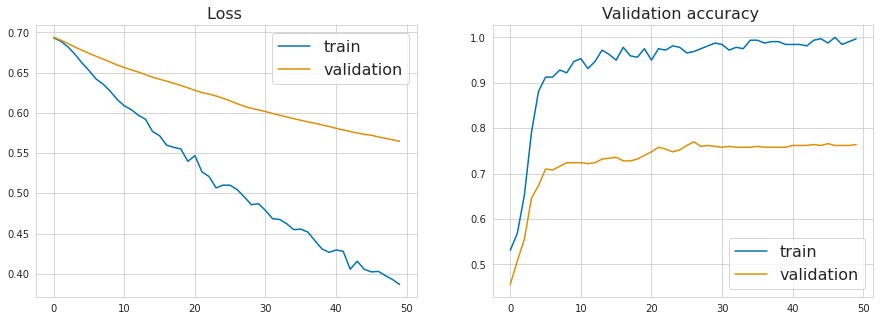

Sequential(
  (layer1): Linear(in_features=5722, out_features=2, bias=True)
)

In [36]:
tf_idf = TfIdf(k, normalize=True) 
tf_idf.fit(texts_train)

X_train_tfidf = tf_idf.transform(texts_train)
X_test_tfidf = tf_idf.transform(texts_test)

model = nn.Sequential()
model.add_module('layer1', nn.Linear(X_train_tfidf.shape[1], 2))
model.to(device, torch.float32)

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt)

X_train_tfidf_torch = torch.tensor(X_train_tfidf).to(device)
X_test_tfidf_torch = torch.tensor(X_test_tfidf).to(device)
y_train_torch = torch.tensor(y_train).to(device)
y_test_torch = torch.tensor(y_test).to(device)

train_model(model, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch)

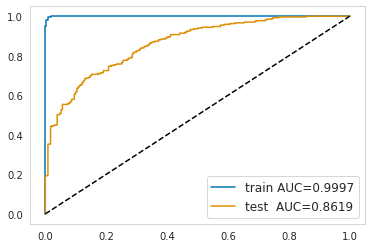

In [37]:
roc_auc_plot(model, X_train_tfidf_torch, X_test_tfidf_torch, y_train, y_test, is_nn=True)

<font color='darkviolet'><i> 
✏️ Результат при нормализации улучшился.
</i></font>

<font color='darkviolet'><i> 
✏️ Попробуем уменьшить число итераций и увеличить $learning\_rate$, так же уменьшим $k$.
</i></font>


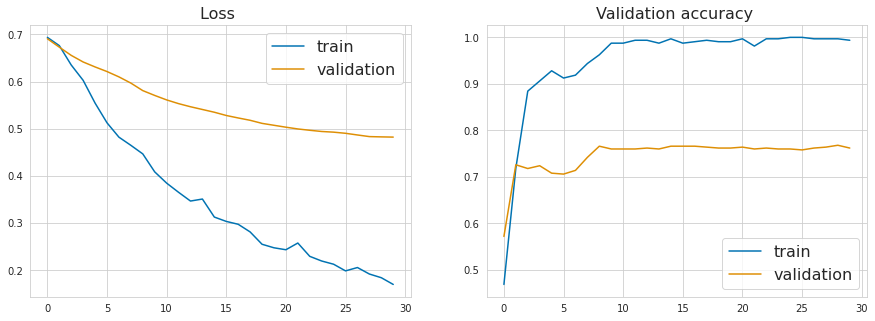

Sequential(
  (layer1): Linear(in_features=5722, out_features=2, bias=True)
)

In [38]:
tf_idf = TfIdf(k // 2, normalize=True) 
tf_idf.fit(texts_train)

X_train_tfidf = tf_idf.transform(texts_train)
X_test_tfidf = tf_idf.transform(texts_test)

model = nn.Sequential()
model.add_module('layer1', nn.Linear(X_train_tfidf.shape[1], 2))
model.to(device, torch.float32)

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.005)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt)

X_train_tfidf_torch = torch.tensor(X_train_tfidf).to(device)
X_test_tfidf_torch = torch.tensor(X_test_tfidf).to(device)
y_train_torch = torch.tensor(y_train).to(device)
y_test_torch = torch.tensor(y_test).to(device)

train_model(model, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=300)

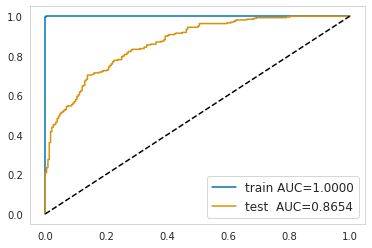

In [39]:
roc_auc_plot(model, X_train_tfidf_torch, X_test_tfidf_torch, y_train, y_test, is_nn=True)

<font color='darkviolet'><i> 
✏️ Достигли такого же качества, но быстрее!.
</i></font>


### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

#### Bag of words + BernoulliNB

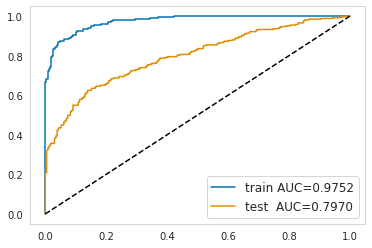

In [40]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB

model = BernoulliNB()
model.fit(X_train_bow, y_train)
roc_auc_plot(model, X_train_bow, X_test_bow, y_train, y_test)

#### TF-IDF + BernoulliNB

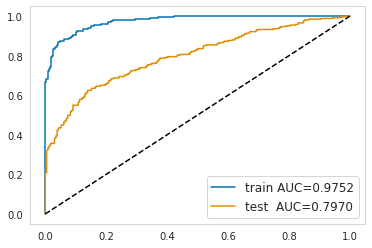

In [41]:
model = BernoulliNB()
model.fit(X_train_tfidf, y_train)
roc_auc_plot(model, X_train_tfidf, X_test_tfidf, y_train, y_test)

#### Bag of words + GaussianNB

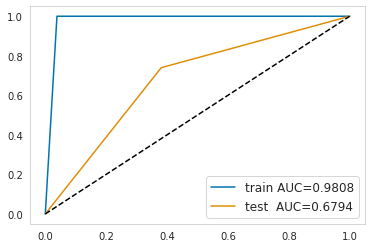

In [42]:
model = GaussianNB()
model.fit(X_train_bow, y_train)
roc_auc_plot(model, X_train_bow, X_test_bow, y_train, y_test)

#### TF-IDF + GaussianNB

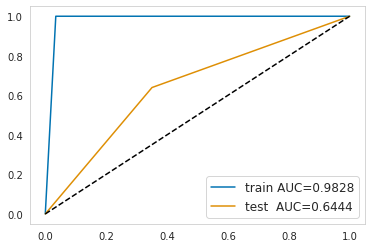

In [43]:
model = GaussianNB()
model.fit(X_train_tfidf, y_train)
roc_auc_plot(model, X_train_tfidf, X_test_tfidf, y_train, y_test)

#### Bag of words + MultinomialNB()

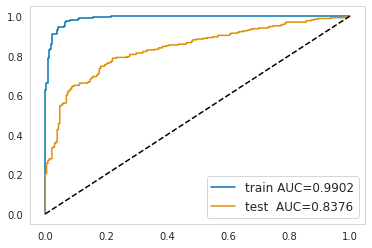

In [44]:
model = MultinomialNB()
model.fit(X_train_bow, y_train)
roc_auc_plot(model, X_train_bow, X_test_bow, y_train, y_test)

#### TF-IDF + MultinomialNB

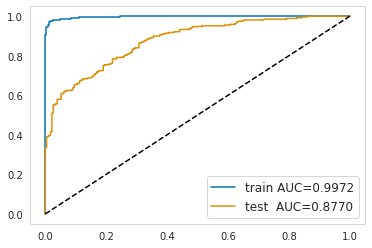

In [45]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)
roc_auc_plot(model, X_train_tfidf, X_test_tfidf, y_train, y_test)

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

<font color='darkviolet'><i> 
✏️ Видим, что среди всех моделей Naive Bayes наилучшей оказалась MultinomialNB. Видимо такое распределение наилучшим образом подходит для векторных представлений из Bow и TF-IDF. TF-IDF + MultinomialNB и вовсе превзошел по качеству линейную регрессию.
Также видим, что:
* Изменение learning rate на более большой позволил за более быстрое число итераций сойтись к решению. Видимо изначально он был выбран малым.
* Число итераций можно было сократить. 
* Параметр k -- размер словаря, влияет на качество модели, но не сказать, что сильно значительно.
* TF-IDF работает точно не хуже, чем BoW, а иногда и лучше.
* MultinomialNB -- лучший выбор для текста среди моделей Наивного Байеса.
* TF-IDF + MultinomialNB показал лучшее качество.
* Между линейной регресси sklean и pytocrh нет особой разницы.
</i></font>


### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [46]:
import gensim.downloader as api


word2vec_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [47]:
def text_to_w2v(text: str, w2v_model) -> np.ndarray:
    w2v_vector = np.mean(np.array([w2v_model[token] for token in text.split() if token in w2v_model]), axis=0)

    if np.isnan(w2v_vector.sum()):
        w2v_vector = np.zeros(w2v_model.vector_size)
    
    if np.linalg.norm(w2v_vector) > 0:
        w2v_vector /= np.linalg.norm(w2v_vector)
    
    return w2v_vector


def w2v_transform(X: np.ndarray, w2v_model) -> np.ndarray:
    return np.stack([text_to_w2v(text, w2v_model) for text in X])

In [48]:
X_train_w2v = w2v_transform(texts_train, word2vec_model)
X_test_w2v = w2v_transform(texts_test, word2vec_model)

In [49]:
X_train_w2v.shape

(500, 300)

#### word2vec + sklearn LogisticRegression



In [50]:
lr_w2v_model = LogisticRegression().fit(X_train_w2v, y_train)

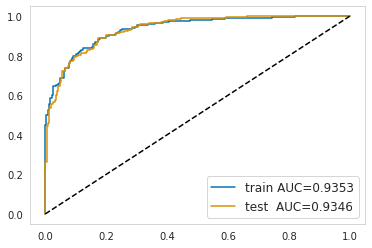

In [51]:
roc_auc_plot(lr_w2v_model, X_train_w2v, X_test_w2v, y_train, y_test)

#### word2vec + PyTorch LogisticRegression

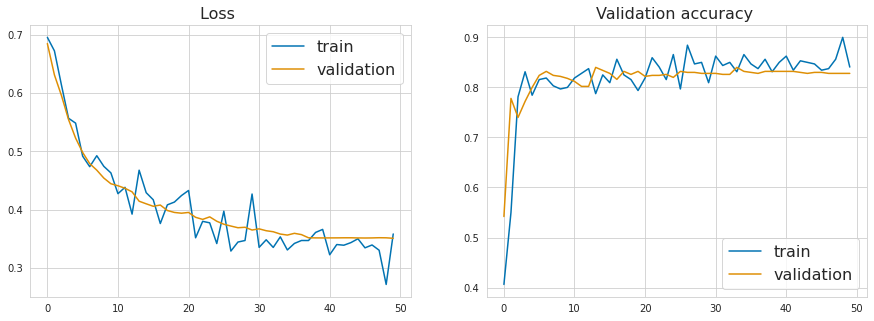

Sequential(
  (layer1): Linear(in_features=300, out_features=2, bias=True)
)

In [52]:
pytorch_lr_model = nn.Sequential()
pytorch_lr_model.add_module('layer1', nn.Linear((X_train_w2v).shape[1], 2))
pytorch_lr_model.to(device, torch.float32)

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(pytorch_lr_model.parameters(), lr=0.005)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt)

X_train_w2v_torch = torch.tensor(X_train_w2v.astype(np.float32)).to(device)
X_test_w2v_torch = torch.tensor(X_test_w2v.astype(np.float32)).to(device)
y_train_torch = torch.tensor(y_train).to(device)
y_test_torch = torch.tensor(y_test).to(device)

train_model(pytorch_lr_model, opt, lr_scheduler, X_train_w2v_torch, y_train_torch, X_test_w2v_torch, y_test_torch, n_iterations=500)

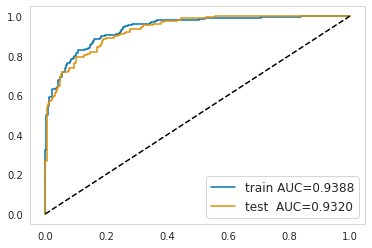

In [53]:
roc_auc_plot(pytorch_lr_model, X_train_w2v_torch, X_test_w2v_torch, y_train, y_test, is_nn=True)

<font color='darkviolet'><i> 
✏️ Видим, что использование предобученных векторных представлений слов (в нашем случае word2vec) сильно увеличивает качество итогового решения:
- ROC AUC увеличился почти на 0.1 по сравнению с BoW + LogisticRegression.
- ROC AUC увеличился почти на 0.6 по сравнению с TF-IDF + MultinomialNB.

Кроме того, мы можем видеть, что модель с word2vec значительно меньше подверждена переобучению. Если ранее ROC AUC для train был на уровне 1.0, то сейчас он соответсвует уровню ROC AUC на валидации.

(К сожалению, я не смог проверить связку word2vec + MultinomialNB, поскольку MultinomialNB требует векторы с неотрицательными коорлинатами, чему не соответсвует word2vec)
</i></font>
